In [ ]:
!git clone --branch no_oxygen
!pip install egnn-pytorch==0.1.11
!pip install plotly

Cloning into 'MLAb'...
remote: Enumerating objects: 8342, done.
remote: Counting objects: 100% (8342/8342), done.
remote: Compressing objects: 100% (8145/8145), done.
remote: Total 8342 (delta 231), reused 8273 (delta 190), pack-reused 0
Receiving objects: 100% (8342/8342), 171.61 MiB | 17.71 MiB/s, done.
Resolving deltas: 100% (231/231), done.
Checking out files: 100% (8090/8090), done.


In [ ]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        
        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params, (list, tuple)) and len(params) > 0 and isinstance(params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0] or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, buffer=[[None, None, None] for _ in range(10)])
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                    p.data.copy_(p_data_fp32)
                elif step_size > 0:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)
                    p.data.copy_(p_data_fp32)

        return loss

In [ ]:
import pandas as pd
import numpy as np
import os
from einops import rearrange, reduce
import matplotlib.pyplot as plt
import copy
import IPython
import torch
from torch import nn, einsum, broadcast_tensors

# Most of the code in this file is based on egnn-pytorch by lucidrains.

class Swish_(nn.Module):
    def forward(self, x):
        return x * x.sigmoid()


SiLU = nn.SiLU if hasattr(nn, 'SiLU') else Swish_


class CoorsNorm(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps
        self.fn = nn.LayerNorm(1)

    def forward(self, coors):
        norm = coors.norm(dim=-1, keepdim=True)
        normed_coors = coors / norm.clamp(min=self.eps)
        phase = self.fn(norm)
        return phase * normed_coors


# classes

class EGNN(nn.Module):
    def __init__(
            self,
            dim,
            m_dim=32,
    ):
        super().__init__()

        edge_input_dim = (dim * 2) + 1

        self.edge_mlp = nn.Sequential(
            nn.Linear(edge_input_dim, edge_input_dim * 2),
            SiLU(),
            nn.Linear(edge_input_dim * 2, m_dim),
            SiLU()
        )

        self.coors_norm = CoorsNorm()

        self.node_mlp = nn.Sequential(
            nn.Linear(dim + m_dim, dim * 2),
            SiLU(),
            nn.Linear(dim * 2, dim),
        )

        self.coors_mlp = nn.Sequential(
            nn.Linear(m_dim, m_dim * 4),
            SiLU(),
            nn.Linear(m_dim * 4, 1)
        )

    def forward(self, feats, coors):
        rel_coors = rearrange(coors, 'b i d -> b i () d') - rearrange(coors, 'b j d -> b () j d')
        rel_dist = (rel_coors ** 2).sum(dim=-1, keepdim=True)

        feats_j = rearrange(feats, 'b j d -> b () j d')
        feats_i = rearrange(feats, 'b i d -> b i () d')
        feats_i, feats_j = broadcast_tensors(feats_i, feats_j)

        edge_input = torch.cat((feats_i, feats_j, rel_dist), dim=-1)

        m_ij = self.edge_mlp(edge_input)

        coor_weights = self.coors_mlp(m_ij)
        coor_weights = rearrange(coor_weights, 'b i j () -> b i j')

        rel_coors = self.coors_norm(rel_coors)

        coors_out = einsum('b i j, b i j c -> b i c', coor_weights, rel_coors) + coors

        m_i = m_ij.sum(dim=-2)

        node_mlp_input = torch.cat((feats, m_i), dim=-1)
        node_out = self.node_mlp(node_mlp_input) + feats

        return node_out, coors_out


class ResEGNN(nn.Module):
    def __init__(self, corrections=4, dims_in=41, **kwargs):
        super().__init__()
        self.layers = nn.ModuleList([EGNN(dim=dims_in, **kwargs) for _ in range(corrections)])

    def forward(self, amino, geom):
        for layer in self.layers:
            amino, geom = layer(amino, geom)
        return geom


class DecoyGen(nn.Module):
    def __init__(self, dims_in=41, decoys=5, **kwargs):
        super().__init__()
        self.blocks = nn.ModuleList([ResEGNN(dims_in=dims_in, **kwargs) for _ in range(decoys)])
        self.decoys = decoys

    def forward(self, amino, geom):
        geoms = torch.zeros((self.decoys, *geom.shape[1:]), device=geom.device)

        for i, block in enumerate(self.blocks):
            geoms[i] = block(amino, geom)

        return geoms

In [ ]:
current_directory = "H3Data"
dict_ = {'A': '0', 'C': '1', 'D': '2', 'E': '3', 'F': '4', 'G': '5', 'H': '6', 'I': '7', 'K': '8', 'L': '9', 'M': '10','N': '11', 'P': '12', 'Q': '13', 'R': '14', 'S': '15', 'T': '16', 'V': '17', 'W': '18', 'Y': '19', '-': '20'}


torch.set_default_dtype(torch.float)
default_type = torch.zeros(2).dtype
device = "cuda" if torch.cuda.is_available() else "cpu"


def encode(x, classes):
    """ One hot encodes a scalar x into a vector of length classes.
    This is the function used for Sequence encoding.
    """
    one_hot = np.zeros(classes)
    one_hot[x] = 1
    return one_hot


def one_hot(num_list, classes=20):
    """ One hot encodes a 1D vector x.
    This is the function used for Sequence encoding.
    """
    end_shape = (len(num_list), classes)
    finish = np.zeros(end_shape)
    for i in range(end_shape[0]):
        finish[i] = encode(num_list[i], classes)
    return finish


def positional_encoding(sequence, n = 5):
    encs = []
    L = len(sequence)
    for i in range(n):
        encs.append(np.cos((2**i)*np.pi*np.arange(L)/L))
        encs.append(np.sin((2**i)*np.pi*np.arange(L)/L))
    
    return np.array(encs).transpose()


def spiral(geom_in):
    gin = geom_in.copy()
    v1 = gin[1] - gin[0]
    v1/= np.linalg.norm(v1) 
    v2 = gin[2] - gin[1]
    v2/= np.linalg.norm(v2) 
    v3 = np.cross(v1,v2)
    v3/= np.linalg.norm(v3) 
    v4 = np.cross(v2,v3) 
    L = len(gin) - 4
    gin[2:-2] += np.array([(v3*np.sin(i) + v4*np.cos(i)) for i in range(L)])

    return gin


def res_to_atom(amino, n_atoms = 4):
    residue_feat = rearrange(amino, "i d -> i () d")
    atom_type = rearrange(torch.eye(n_atoms, device = amino.device), "a d -> () a d")

    i = residue_feat.shape[0]
    atom_feat = torch.cat([residue_feat.repeat(1,n_atoms,1), atom_type.repeat(i,1,1)], dim = -1)
    return atom_feat

def which_loop(loop_seq, cdr, CDRs):
    loop = np.zeros((len(loop_seq),len(CDRs)+1))
    loop[:,-1] = 1
    loop[2:-2] = np.array([1.0 if cdr == x else 0.0 for x in (CDRs + ["Anchor"])])[None].repeat(len(loop_seq)-4, axis = 0)
    return loop


class DataStorer:
    def __init__(self, data, data_dir = "H3Data", device = device, CDRs = ["H1", "H2", "H3", "L1", "L2", "L3"]):
        self.data = data.reset_index(drop = True)
        self.full_atoms_path = os.path.join(data_dir, "data")
        self.device = device

        self.geom_ins = []
        self.aminos = []
        self.geom_out = []
        self.ids = []
        self.sequences = []
        self.CDRs = CDRs
        self.CDR_slices = {
            "H1":slice(23,36),
            "H2":slice(51,63),
            "H3":slice(100,124),
            "L1":slice(155,176),
            "L2":slice(187,198),
            "L3":slice(226,245)}

        
        self.__populate()
        
    def __populate(self):
        device = self.device
        dict_ = {'A': '0', 'C': '1', 'D': '2', 'E': '3', 'F': '4', 'G': '5', 'H': '6', 'I': '7', 'K': '8', 'L': '9', 'M': '10','N': '11', 'P': '12', 'Q': '13', 'R': '14', 'S': '15', 'T': '16', 'V': '17', 'W': '18', 'Y': '19'}
        for i in range(len(self.data)):
            latest_sequence = self.data.Sequence[i]
            latest_ID = self.data.ID[i]

            full_geom = np.load(os.path.join(self.full_atoms_path, latest_ID + ".npy"))

            geoins = []
            geouts = []
            aminos = []
            seq = ""

            for cdr in self.CDR_slices:

                if cdr not in self.CDRs:
                    continue

                loop_seq = latest_sequence[self.CDR_slices[cdr]].replace("-", "")
                seq += loop_seq
                geom = full_geom[self.CDR_slices[cdr]]

                if any([x != x for x in geom[:2,:].flatten()]) or any([x != x for x in geom[-2:,:].flatten()]):
                    continue # Missing anchors

                geom = geom[geom[:,0,0] == geom[:,0,0]] #remove nans

                dists = ((geom[1:,0] - geom[:-1,0])**2).sum(-1)**(1/2)
                if any([not (2.8 < x < 4.8) for x in dists]): 
                    continue # Missing CA atoms

                one_hot_encoding = one_hot(np.array([int(dict_[c]) for c in loop_seq]))
                positional = positional_encoding(loop_seq)
                loop = which_loop(loop_seq, cdr, list(self.CDR_slices))
                encoding = np.concatenate([one_hot_encoding, positional, loop], axis = 1)

                geom_in = geom.copy()
                geom_in[1:-1] = np.linspace(geom_in[1], geom_in[-2], len(geom_in)-2)
                #geom_in = spiral(geom_in)
                
                geoins.append(torch.tensor(geom_in, dtype = default_type))
                geouts.append(torch.tensor(geom, dtype = default_type))
                aminos.append(torch.tensor(encoding, dtype = default_type))

            if len(geoins) != len(self.CDRs):
                continue

            self.geom_ins.append(rearrange(torch.cat(geoins).to(device), "i a d -> () (i a) d"))
            self.aminos.append(rearrange(res_to_atom(torch.cat(aminos).to(device)), "i a d -> () (i a) d"))
            self.geom_out.append(rearrange(torch.cat(geouts).to(device), "i a d -> () (i a) d"))
            self.ids.append(latest_ID)
            self.sequences.append(seq)
                             
    def __len__(self):
        return len(self.geom_ins)

def rmsd(prediction, truth):
    dists = (prediction - truth).pow(2).sum(-1)
    return torch.sqrt(dists.mean(-1)).mean()


def rmsds(preds, true):
    return  torch.sort((preds - true).pow(2).sum(-1).mean(-1).pow(1/2))[0]

def length_penalty(pred):
    return ((((pred[:,1:]-pred[:,:-1])**2).sum(-1).pow(1/2) - 3.802).pow(2)).mean()

def different_penalty(pred):
    return -(rearrange(pred, "i n d -> i () n d") - rearrange(pred, "j n d -> () j n d")).pow(2).mean()

def dist_check(pred, amino):
    err = 0
    for i in range(6):
        CDR = rearrange(pred[:,amino[0,:,30+i]==1.0], "d (r a) p -> d a r p", a = 4)
        # CA-CA
        err += (((CDR[:,0,1:] - CDR[:,0,:-1]).pow(2).sum(-1).pow(1/2) - 3.82).abs() - 0.12).clamp(0).mean()
        # CA-N
        err += (((CDR[:,0] - CDR[:,1]).pow(2).sum(-1).pow(1/2) - 1.47).abs() - 0.01).clamp(0).mean()
        # CA-C
        err += (((CDR[:,0] - CDR[:,2]).pow(2).sum(-1).pow(1/2) - 1.53).abs() - 0.01).clamp(0).mean()
        # C-N
        err += (((CDR[:,2,:-1] - CDR[:,1,1:]).pow(2).sum(-1).pow(1/2) - 1.34).abs() - 0.01).clamp(0).mean()
        # CA-CB
        CDR2 = rearrange(pred[:,(amino[0,:,30+i]==1.0) & (amino[0,:,5] != 1.0)], "d (r a) p -> d a r p", a = 4)
        err += (((CDR2[:,0] - CDR2[:,-1]).pow(2).sum(-1).pow(1/2) - 1.54).abs() - 0.01).clamp(0).mean()

    return err

def cdr_seqs(seq):
    CDR_slices = {
    "H1":slice(23,36),
    "H2":slice(51,63),
    "H3":slice(100,124),
    "L1":slice(155,176),
    "L2":slice(187,198),
    "L3":slice(226,245)}
    return  "/".join([seq[CDR_slices[x]].replace("-", "") for x in CDR_slices])

## Fv Sequence Positions

Heavy chain: [:133]

Light chain: [133:]

CDR-H1: [25:34] -> With anchors [23:36]

CDR-H2: [53:61] -> With anchors [51:63]

CDR-H3: [102:122] -> With anchors [100:124]

CDR-L1: [157:174] -> With anchors [155:176]

CDR-L2: [189:196] -> With anchors [187:198]

CDR-L3: [228:243] -> With anchors [226:245]


In [ ]:
extra = pd.read_csv(os.path.join(current_directory, "new_data.csv"))
data = pd.read_csv(os.path.join(current_directory, "data.csv"))
data = pd.concat([data,extra])
test = pd.read_csv(os.path.join(current_directory, "validation_data.csv"))

data["CDRs"] = [cdr_seqs(x) for x in data.Sequence]
test["CDRs"] = [cdr_seqs(x) for x in test.Sequence]

data = data[(~data.CDRs.isin(test.CDRs))]
assert not any(test.ID.isin(data.ID).values) , "You got some test in your train"


a = DataStorer(data)
b = DataStorer(test)


In [ ]:
def atom_dist(geom):
    return ((geom[:,None] - geom[:,:,None]).mean(0).pow(2).sum(-1) + 1e-8).pow(1/2) 

def atom_dist_penal(geom, pred):
    true_ds = atom_dist(geom)
    pred_ds = atom_dist(pred)
    mask = true_ds < 4.0
    return (true_ds-pred_ds)[mask].pow(2).mean()

In [ ]:
corr = 4
norm = True
decay = 1e-3
lr = 1e-3
m_dim = 32
advers = 5

model = DecoyGen().to(device = device).float()
mean_val_losses = []
mean_train_losses = []

In [ ]:

optim = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
epoch_val_loss = []
with torch.no_grad():
    for j in range(len(b)):
        geom_in, amino, geom = b.geom_ins[j], b.aminos[j], b.geom_out[j]
        pred = model(amino,geom_in)
        loss = rmsd(geom, pred) + 5*(20*atom_dist_penal(geom, pred) + dist_check(pred.mean(0, keepdim = True), amino))
        epoch_val_loss.append(loss.item()) 
    mean_val_losses.append(np.mean(epoch_val_loss))

mean_val_losses

[4.387412910660108]

In [ ]:
patience = 0
i = 0

In [ ]:

optim.zero_grad()

out = display(IPython.display.Pretty("Starting"), display_id=True)

batch = 4
epochs = 5000
for i in range(i,epochs):
    epoch_loss = []
    epoch_val_loss = []
    H3_rmsds = []
    order = np.random.permutation(range(len(a)))
    model.train()
    for k in range(len(a)//batch):
        for l in range(batch):
            j = order[k*batch + l]
            geom_in, amino, geom, seq = a.geom_ins[j], a.aminos[j], a.geom_out[j], a.sequences[j]
            pred = model(amino, geom_in)
            loss = rmsd(geom, pred) + 4.0*(20*atom_dist_penal(geom, pred) + dist_check(pred.mean(0, keepdim = True), amino))
            if loss.item() != loss.item():
                print(a.ids[j])
                raise Exception("Shit went to Nan")
            #loss.register_hook(lambda grad: print(grad))
            (loss/batch*advers).backward()
            
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optim.step()
        optim.zero_grad()
        epoch_loss.append(loss.item())
        text = "{:.2f}%    {:.2f}    {:.2f}".format((k*batch + l)/len(a)*100, epoch_loss[-1], atom_dist_penal(geom, pred).item())
        out.update(IPython.display.Pretty(text))
    model.eval()
    with torch.no_grad():
        for j in range(len(b)):
            geom_in, amino, geom = b.geom_ins[j], b.aminos[j], b.geom_out[j]
            pred = model(amino, geom_in)
            loss = rmsd(geom, pred) + 4*(20*atom_dist_penal(geom, pred) + dist_check(pred.mean(0, keepdim = True), amino))
            epoch_val_loss.append(loss.item()) 
            H3_rmsds.append(rmsd(pred.mean(0)[amino[0,:,32]==1.0], geom.mean(0)[amino[0,:,32]==1.0]).item())
        mean_val_losses.append(np.mean(epoch_val_loss))
        mean_train_losses.append(np.mean(epoch_loss))
    print("{epoch} {train_loss:.4f} {val_loss:.4f} {H3:.4f}".format(epoch = i, train_loss = np.mean(epoch_loss), val_loss  = np.mean(epoch_val_loss), H3 = np.mean(H3_rmsds)))
    if np.min(mean_val_losses) == mean_val_losses[-1]:
        best_model = copy.deepcopy(model)
        torch.save(best_model.state_dict(), "drive/MyDrive/DPhil_Project/fv_models/finetune")
        torch.save(optim.state_dict(), "drive/MyDrive/DPhil_Project/optimizers/finetune")
        patience = 0
    else:
        patience += 1
        if patience > 100:
            break

1.78%    3.94    0.02

0 4.6178 4.6426 2.6269
1 4.0413 4.9651 2.6006
2 4.1507 5.2050 2.6349
3 4.2399 5.3429 2.6324


KeyboardInterrupt: ignored

In [ ]:
best_model = model

In [ ]:

def mean_std(xs):
  return np.mean(xs), np.std(xs)
  

caca = []
can = []
cac = []
cn = []
cacb = []
with torch.no_grad():
    for j in range(len(b)):
        geom_in, amino, geom = b.geom_ins[j].float(), b.aminos[j].float(), b.geom_out[j].float()
        pred = geom#best_model(amino, geom_in).mean(0, keepdim = True)
        for i in range(6):
            CDR = rearrange(pred[:,amino[0,:,30+i]==1.0], "d (r a) p -> d a r p", a = 4)
            # CA-CA
            caca +=  list((CDR[:,0,1:] - CDR[:,0,:-1]).pow(2).sum(-1).pow(1/2).detach().cpu().numpy().flatten())
            # CA-N
            can += list((CDR[:,0,:-1] - CDR[:,1,1:]).pow(2).sum(-1).pow(1/2).detach().cpu().numpy().flatten())
            # CA-C
            cac += list((CDR[:,0] - CDR[:,2]).pow(2).sum(-1).pow(1/2).detach().cpu().numpy().flatten())
            # C-N
            cn += list((CDR[:,2,:] - CDR[:,1,:]).pow(2).sum(-1).pow(1/2).detach().cpu().numpy().flatten())
            # CA-CB
            CDR2 = rearrange(pred[:,(amino[0,:,30+i]==1.0) & (amino[0,:,5] != 1.0)], "d (r a) p -> d a r p", a = 4)
            cacb += list((CDR2[:,0] - CDR2[:,-1]).pow(2).sum(-1).pow(1/2).detach().cpu().numpy().flatten())

In [ ]:
mean_std(caca), mean_std(can), mean_std(cac), mean_std(cn), mean_std(cacb)

((3.7933986, 0.11556624),
 (2.4308417, 0.022973968),
 (1.5245744, 0.011339904),
 (2.4650629, 0.04771689),
 (1.5347517, 0.014123985))

In [ ]:
CDRs = ["H1", "H2", "H3", "L1", "L2", "L3"]
losses = {x:[] for x in CDRs}

model.eval().cuda()
with torch.no_grad():
    for j in range(len(b)):
        geom_in, amino, geom = b.geom_ins[j], b.aminos[j], b.geom_out[j]
        try:
            pred = model(amino, geom_in)
        except Exception as e:
            print(j)
            raise e

        for i,CDR in enumerate(CDRs):
            losses[CDR].append(rmsd(pred.mean(0)[amino[0,:,30+i]==1.0][::4], geom[:,amino[0,:,30+i]==1.0][0,::4]).mean().item())
        #deviation_scores.append(rmsds(pred[:,None, 2:-2],pred[None,:,2:-2]).mean().item())
    

In [ ]:
b = DataStorer(test, device = device)
best_losses = []
mean_losses = []
worst_losses = []
all_losses = []
deviation_scores = []

best_model.eval()
cdr_i = 32
with torch.no_grad():
    for j in range(len(b)):
        geom_in, amino, geom = b.geom_ins[j], b.aminos[j], b.geom_out[j]
        pred = best_model(amino, geom_in)
        loss = rmsds(pred[:,amino[0,:,cdr_i] == 1.0],geom[:,amino[0,:,cdr_i] == 1.0])
        best_losses.append(loss[0].item())
        mean_losses.append(rmsd(pred.mean(0)[amino[0,:,cdr_i] == 1.0], geom[:,amino[0,:,cdr_i] == 1.0]).item())
        deviation_scores.append(rmsds(pred[:,amino[0,:,cdr_i] == 1.0][:,None],pred[:,amino[0,:,cdr_i] == 1.0][None]).sum().item()/20)
    

In [ ]:
filt = np.array(deviation_scores) < 0.7
good_preds = np.array(mean_losses)[filt]
np.mean(mean_losses), np.mean(best_losses)

(2.651808309058348, 2.46801121160388)

Text(0.5, 0, 'RMSD (Å)')

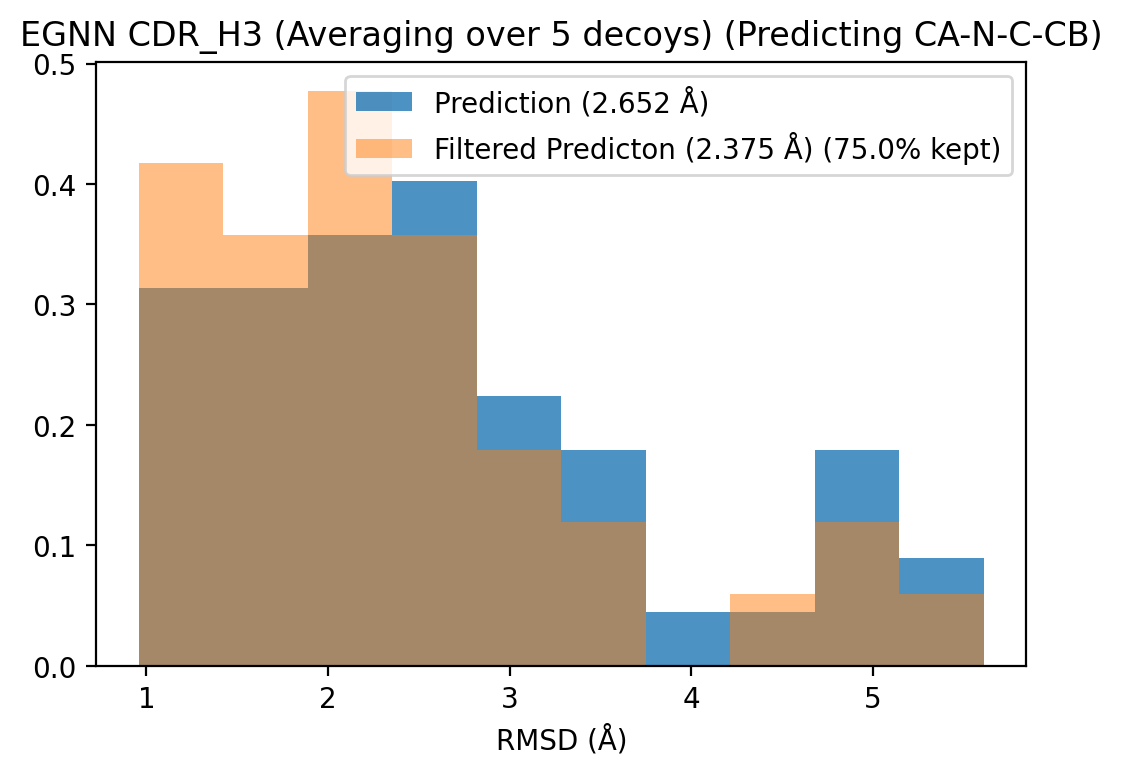

In [ ]:
plt.figure(dpi = 200)

description = "EGNN CDR_H3 (Averaging over {} decoys) (Predicting CA-N-C-CB)".format(advers)
plt.title(description)
plt.hist(mean_losses, alpha = 0.8, density=True)
#plt.hist(best_losses, alpha = 0.5, density =True)
good_preds = np.array(mean_losses)[np.array(deviation_scores) < 1.88]
plt.hist(good_preds, alpha = 0.5, density = True)
plt.legend(["Prediction ({:.3f} Å)".format(np.mean(mean_losses)), "Filtered Predicton ({:.3f} Å) ({:.1f}% kept)".format(np.mean(good_preds), 100*len(good_preds)/len(best_losses))])
plt.xlabel("RMSD (Å)")
#plt.savefig("results/{}.png".format(description))
# "Best Decoy ({:.3f} Å)".format(np.mean(best_losses)),

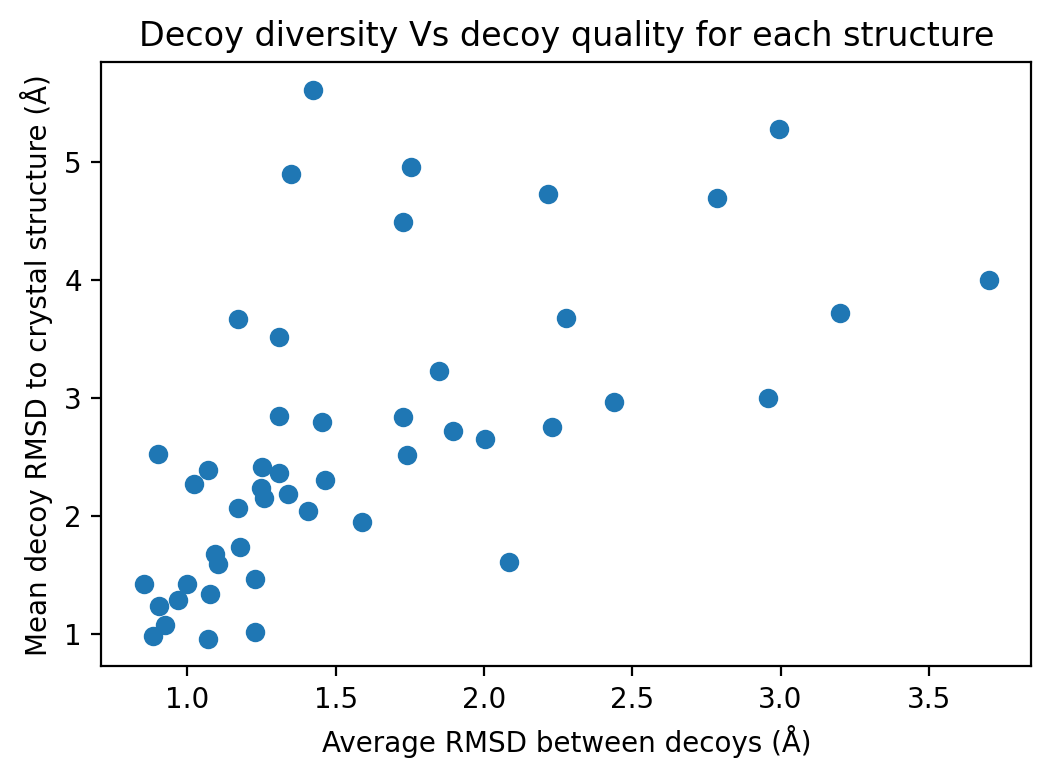

In [ ]:
plt.figure(dpi=200)
plot_losses = np.array([x.cpu().detach().numpy() for x in all_losses])
plt.plot(deviation_scores, mean_losses, "o")
plt.xlabel("Average RMSD between decoys (Å)")
plt.ylabel("Mean decoy RMSD to crystal structure (Å)")
plt.title("Decoy diversity Vs decoy quality for each structure")
plt.show()

In [ ]:
import plotly
import plotly.graph_objects as go
def data_to_plot(xs, names):
    ret = []
    for i,x0 in enumerate(xs):
        x0 = x0.cpu().detach().numpy().transpose()
        ret.append(go.Scatter3d(x=x0[0], y=x0[1], z=x0[2], name = names[i], marker=dict(size=2)))
    return ret

test = pd.read_csv(os.path.join(current_directory, "test_data.csv"))
c = DataStorer(test)

j = np.random.randint(len(c))

with torch.no_grad():
    geom_in, amino, geom = c.geom_ins[j], c.aminos[j], c.geom_out[j]
    pred = model(amino, geom_in)

cdr_i = 32
fig = go.Figure(data=data_to_plot([geom_in[amino[:,:,cdr_i] == 1.0][::4]] + [pred.mean(0)[amino[0,:,cdr_i] == 1.0][::4]] + [geom[amino[:,:,cdr_i] == 1.0][::4]],
                                  ["Inp"] + ["Prediction"]+["Truth"]))
fig.update_layout(title = "H3 loop Prediction for {}".format(c.ids[j]))
fig.show()